In [1]:
import os, pandas as pd, numpy as np
from fredapi import Fred
fred = Fred(api_key='cba33361256956afaa259454a226507f')
#fred = Fred(api_key=os.getenv('FRED_API_KEY'))

In [2]:
verified_series = {
    'Recession': 'USREC',
    '10Y Treasury': 'GS10',
    '3Y Treasury': 'TB3MS',
    'Unemployment': 'UNRATE',
    'Interest Rates': 'FEDFUNDS'
}

# Test the series to make usre I got the names right
for name, sid in verified_series.items():
    try:
        data = fred.get_series(sid)
        print(f"✓ {name} ({sid}): SUCCESS")
    except Exception as e:
        print(f"✗ {name} ({sid}): FAILED - {e}")

✓ Recession (USREC): SUCCESS
✓ 10Y Treasury (GS10): SUCCESS
✓ 3Y Treasury (TB3MS): SUCCESS
✓ Unemployment (UNRATE): SUCCESS
✓ Interest Rates (FEDFUNDS): SUCCESS


In [3]:
df = pd.DataFrame({name: fred.get_series(sid) for name, sid in verified_series.items()})
df.index = pd.to_datetime(df.index)
df = df.resample('ME').mean()
df = df[df.index >= '1955-01-01']
df['10-3Spread'] = df['10Y Treasury']- df['3Y Treasury']
df

,Recession,10Y Treasury,3Y Treasury,Unemployment,Interest Rates,10-3Spread
1955-01-31,0.0,2.61,1.22,4.9,1.39,1.39
1955-02-28,0.0,2.65,1.17,4.7,1.29,1.48
1955-03-31,0.0,2.68,1.28,4.6,1.35,1.40
1955-04-30,0.0,2.75,1.59,4.7,1.43,1.16
1955-05-31,0.0,2.76,1.45,4.3,1.43,1.31
...,...,...,...,...,...,...
2025-07-31,0.0,4.39,4.25,4.2,4.33,0.14
2025-08-31,0.0,4.26,4.12,4.3,4.33,0.14
2025-09-30,0.0,4.12,3.92,4.4,4.22,0.20
2025-10-31,0.0,4.06,3.82,NaN,4.09,0.24


In [4]:
#Split the data into 2 sets test and train
train_df = df[df.index <= '2005-12-31']
test_df = df[df.index > '2005-12-31']
train_df = train_df[['Recession','Unemployment','Interest Rates','10-3Spread']]
test_df = test_df[['Recession','Unemployment','Interest Rates','10-3Spread']]

In [5]:
from sklearn.preprocessing import StandardScaler
# Scale the data and make sure to not apply to target column
X_train = train_df.drop('Recession', axis = 1)
Y_train = train_df['Recession']
X_test = test_df.drop('Recession', axis = 1)
Y_test = test_df['Recession']

scaler = StandardScaler()

train_scaled_values = scaler.fit_transform(X_train)
test_scaled_values = scaler.transform(X_test)
train_scaled = pd.DataFrame(train_scaled_values, columns = X_train.columns, index = X_train.index)
test_scaled = pd.DataFrame(test_scaled_values, columns = X_test.columns, index = X_test.index)
train_scaled

,Unemployment,Interest Rates,10-3Spread
1955-01-31,-0.634443,-1.299272,-0.006137
1955-02-28,-0.773288,-1.328979,0.068975
1955-03-31,-0.842710,-1.311154,0.002209
1955-04-30,-0.773288,-1.287389,-0.198087
1955-05-31,-1.050977,-1.287389,-0.072902
...,...,...,...
2005-08-31,-0.634443,-0.672455,-0.481840
2005-09-30,-0.565021,-0.636807,-0.515222
2005-10-31,-0.565021,-0.589275,-0.540259
2005-11-30,-0.565021,-0.523920,-0.615370


In [6]:
class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000, method='GD', verbose=False):
        """
        Args:
            learning_rate: How big of a step to take (only for GD).
            n_iterations: How many times to loop over the data.
            method: 'GD' for Gradient Descent, 'Newton' for Newton's Method.
            verbose: If True, print cost every 100 steps.
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.method = method
        self.verbose = verbose
        self.theta = None  # These are our weights!
        self.cost_history = []

    def _sigmoid(self, z):
        # Clip z to prevent "overflow" errors (computer can't handle e^1000)
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, h, y):
        # This is "Log Loss" (Binary Cross Entropy)
        # We add 1e-15 to avoid taking log(0) which is -Infinity
        m = y.shape[0]
        return -np.sum(y * np.log(h + 1e-15) + (1 - y) * np.log(1 - h + 1e-15)) / m

    def fit(self, X, y):
        """
        The Training Loop.
        X: The features (Shape: Rows x Features)
        y: The target labels (Shape: Rows x 1)
        """
        # 1. Add the "Bias" column (column of 1s) to X
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        m, n = X_bias.shape
        
        # 2. Initialize weights (theta) to zeros
        self.theta = np.zeros(n)

        # 3. The Loop
        for i in range(self.n_iterations):
            # A. PREDICT: Z = X * theta
            z = np.dot(X_bias, self.theta)
            h = self._sigmoid(z) # h is our probability (0 to 1)

            # B. MEASURE: Calculate Gradient (Slope)
            # Gradient = X.T * (Prediction - Actual) / m
            gradient = np.dot(X_bias.T, (h - y)) / m

            # C. UPDATE: Move theta
            if self.method == 'GD':
                # Gradient Descent: Step down the hill
                self.theta -= self.learning_rate * gradient

            elif self.method == 'Newton':
                # Newton's Method: Jump to the bottom
                # Hessian = (X.T * S * X) / m
                S = h * (1 - h)
                H = np.dot(X_bias.T, X_bias * S.reshape(-1, 1)) / m
                
                # Inverse the Hessian
                H_inv = np.linalg.pinv(H)
                
                # Update: theta = theta - H^-1 * gradient
                self.theta -= np.dot(H_inv, gradient)

            # D. LOGGING: Keep track of error
            cost = self._compute_loss(h, y)
            self.cost_history.append(cost)

            if self.verbose and i % 100 == 0:
                print(f"Iteration {i}: Cost = {cost:.5f}")

    def predict_proba(self, X):
        """Return raw probabilities"""
        # We must add the bias column here too!
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]
        z = np.dot(X_bias, self.theta)
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        """Return 0 or 1"""
        return (self.predict_proba(X) >= threshold).astype(int)

In [7]:
# Running the model
model = LogisticRegressionFromScratch(method='Newton', n_iterations=20, verbose=True)
model.fit(train_scaled, Y_train)

# See the results
print("My Weights:", model.theta)

Iteration 0: Cost = 0.69315
My Weights: [-2.01199506  0.38326444  0.41590635 -0.21285609]


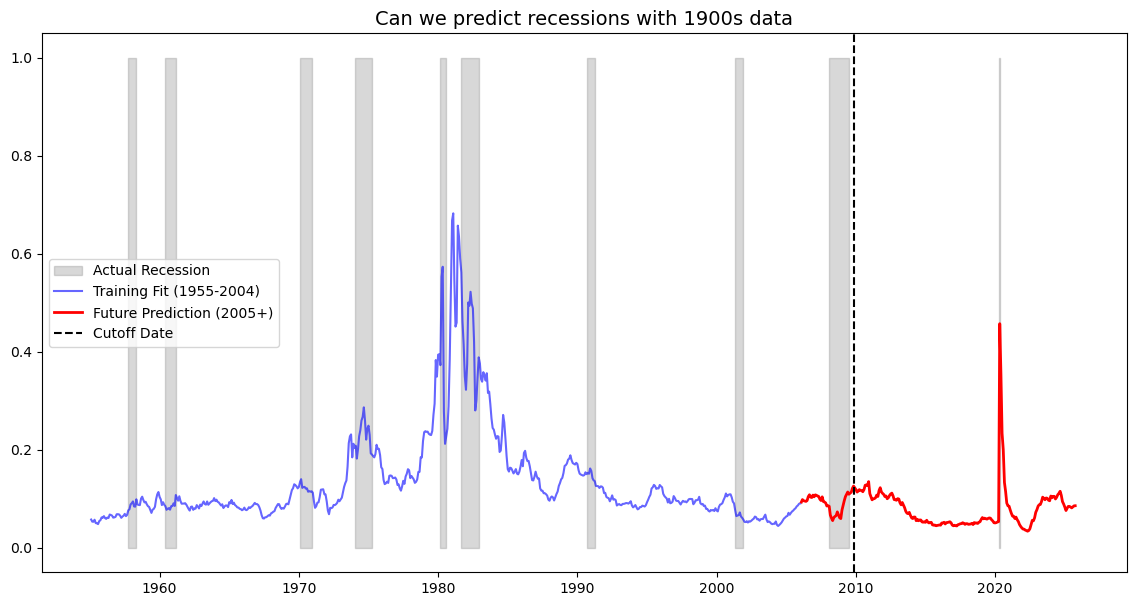

In [8]:
import matplotlib.pyplot as plt

# Get probabilities for BOTH sets
probs_train = model.predict_proba(train_scaled)
probs_test = model.predict_proba(test_scaled)

# Combine them for plotting
full_probs = np.concatenate([probs_train, probs_test])
full_dates = df.index

plt.figure(figsize=(14, 7))

# 1. Plot the recessions in gray bars
plt.fill_between(full_dates, 0, 1, where=df['Recession']==1, 
                 color='grey', alpha=0.3, label='Actual Recession')

# 2. Plot Training Predictions (Blue) - "The Memory"
plt.plot(train_df.index, probs_train, color='blue', alpha=0.6, label='Training Fit (1955-2004)')

# 3. Plot Test Predictions (Red) - "The Forecast"
plt.plot(test_df.index, probs_test, color='red', linewidth=2, label='Future Prediction (2005+)')

plt.axvline(pd.to_datetime('2009-10-31'), color='black', linestyle='--', label='Cutoff Date')
plt.title('Can we predict recessions with 1900s data', fontsize=14)
plt.legend()
plt.show()

In [9]:
df_lagged = df.copy()
df_lagged['10-3Spread'] = df_lagged['10-3Spread'].shift(12)
df_lagged['Interest Rates'] = df_lagged['Interest Rates'].shift(12)

df_lagged['Unemployment'] = df_lagged['Unemployment'].shift(3)
df_lagged = df_lagged.dropna()

In [10]:
train_df_lagged = df_lagged[df_lagged.index <= '2005-12-31']
test_df_lagged = df_lagged[df_lagged.index > '2005-12-31']
train_df_lagged = train_df_lagged[['Recession','Unemployment','Interest Rates','10-3Spread']]
test_df_lagged = test_df_lagged[['Recession','Unemployment','Interest Rates','10-3Spread']]

In [11]:
X_train_lagged = train_df_lagged.drop('Recession', axis = 1)
Y_train_lagged = train_df_lagged['Recession']
X_test_lagged = test_df_lagged.drop('Recession', axis = 1)
Y_test_lagged = test_df_lagged['Recession']

scaler = StandardScaler()

train_lagged_scaled_values = scaler.fit_transform(X_train_lagged)
test_lagged_scaled_values = scaler.transform(X_test_lagged)
train_lagged_scaled = pd.DataFrame(train_lagged_scaled_values, columns = X_train_lagged.columns, index = X_train_lagged.index)
test_lagged_scaled = pd.DataFrame(test_lagged_scaled_values, columns = X_test_lagged.columns, index = X_test_lagged.index)
train_lagged_scaled

,Unemployment,Interest Rates,10-3Spread
1956-01-31,-1.066883,-1.309397,-0.010293
1956-02-29,-1.136198,-1.338990,0.064212
1956-03-31,-1.136198,-1.321234,-0.002014
1956-04-30,-1.274829,-1.297559,-0.200694
1956-05-31,-1.344145,-1.297559,-0.076519
...,...,...,...
2005-08-31,-0.512358,-1.297559,1.156948
2005-09-30,-0.581673,-1.244291,0.892042
2005-10-31,-0.581673,-1.199901,0.776146
2005-11-30,-0.650989,-1.149593,0.594023


In [12]:
# Run your custom model
model = LogisticRegressionFromScratch(method='Newton', n_iterations=20, verbose=True)
model.fit(train_lagged_scaled, Y_train_lagged)

# See the results
print("My Weights:", model.theta)

Iteration 0: Cost = 0.69315
My Weights: [-2.65142589 -0.31913597  0.64162207 -1.36194188]


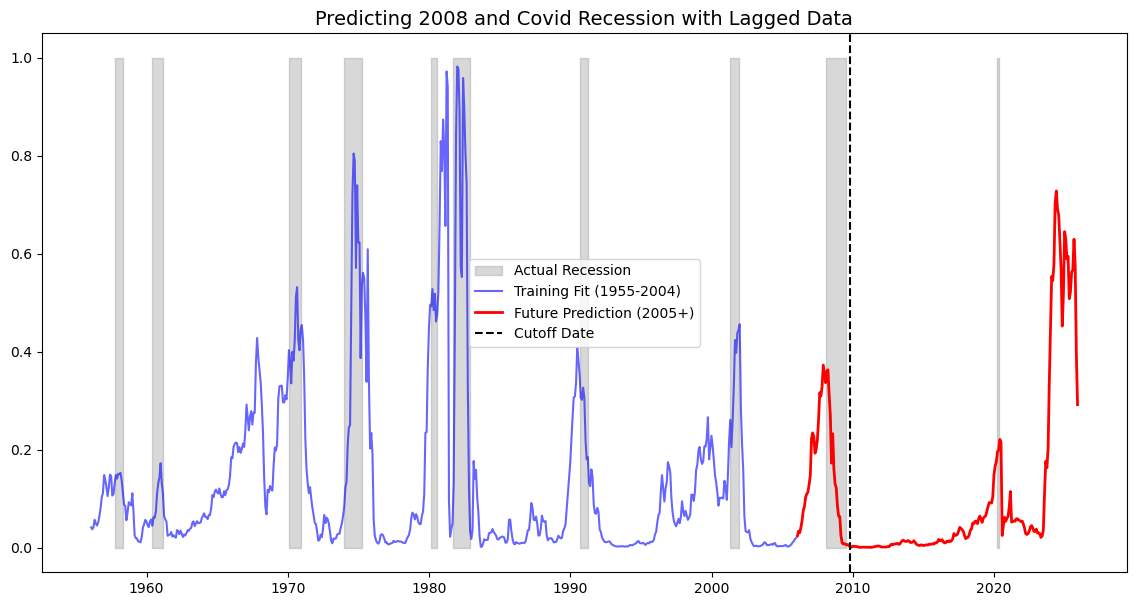

In [13]:
# Get probabilities for BOTH sets
probs_train = model.predict_proba(train_lagged_scaled)
probs_test = model.predict_proba(test_lagged_scaled)

# Combine them for plotting
full_probs = np.concatenate([probs_train, probs_test])
full_dates = df_lagged.index

plt.figure(figsize=(14, 7))

# 1. Plot the "Truth" (Grey Bars)
plt.fill_between(full_dates, 0, 1, where=df_lagged['Recession']==1, 
                 color='grey', alpha=0.3, label='Actual Recession')

# 2. Plot Training Predictions (Blue) - "The Memory"
plt.plot(train_df_lagged.index, probs_train, color='blue', alpha=0.6, label='Training Fit (1955-2004)')

# 3. Plot Test Predictions (Red) - "The Forecast"
plt.plot(test_df_lagged.index, probs_test, color='red', linewidth=2, label='Future Prediction (2005+)')

plt.axvline(pd.to_datetime('2009-10-31'), color='black', linestyle='--', label='Cutoff Date')
plt.title('Predicting 2008 and Covid Recession with Lagged Data', fontsize=14)
plt.legend()
plt.show()